In [151]:
using AlgorithmicRecourse
using MLDatasets
using MLDatasets.MNIST: convert2image
train_x, train_y = MNIST.traindata()
test_x,  test_y  = MNIST.testdata();

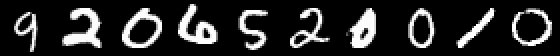

In [152]:
using Images, Random, StatsBase
Random.seed!(1234)
n_samples = 10
samples = train_x[:,:,sample(1:end, n_samples, replace=false)]
mosaicview([convert2image(samples[:,:,i]) for i ∈ 1:n_samples]...,ncol=n_samples)

## Classifier

In [153]:
output_dim = 10
input_dim = prod(size(train_x[:,:,1]))
hidden_dim = 32

32

### Single MLP

In [154]:
using Flux
using Flux: onehotbatch, onecold
y = Flux.unstack(Flux.onehotbatch(train_y, 0:9),2)
x = Flux.unstack(Flux.flatten(train_x), 2)
kw_args = (input_dim=input_dim,n_hidden=hidden_dim,output_dim=output_dim)
nn = build_model(;kw_args...)
loss(x, y) = Flux.Losses.logitcrossentropy(nn(x), y)
data = zip(x,y);

In [155]:
using Flux.Optimise: update!, ADAM
using Statistics
opt = ADAM()
epochs = 10
avg_loss(data) = mean(map(d -> loss(d[1],d[2]), data))
accuracy(data) = mean(map(d -> onecold(softmax(nn(d[1])), 0:9) .== onecold(d[2], 0:9), data))

if false
  for epoch = 1:epochs
    for d in data
      gs = gradient(params(nn)) do
        l = loss(d...)
      end
      update!(opt, params(nn), gs)
    end
    @info "Epoch " * string(epoch)
    @show accuracy(data)
  end
  using BSON: @save
  @save "data/MNIST.bson" nn
end

In [156]:
using BSON: @load
@load "data/MNIST.bson" nn
test_data = zip(Flux.unstack(Flux.flatten(test_x), 2),Flux.unstack(Flux.onehotbatch(test_y, 0:9),2))
accuracy(test_data)

0.9559

In [157]:
using AlgorithmicRecourse, AlgorithmicRecourse.Models
import AlgorithmicRecourse.Models: logits, probs # import functions in order to extend

# Step 1)
struct NeuralNetwork <: Models.FittedModel
    nn::Any
end

# Step 2)
logits(𝑴::NeuralNetwork, X::AbstractArray) = 𝑴.nn(X)
probs(𝑴::NeuralNetwork, X::AbstractArray)= softmax(logits(𝑴, X))
𝑴 = NeuralNetwork(nn);

### Deep ensemble

In [158]:
using AlgorithmicRecourse: build_ensemble, forward, save_ensemble, load_ensemble
𝓜 = build_ensemble(5;kw=kw_args)
if false
    𝓜, anim = forward(𝓜, data, opt, n_epochs=epochs, plot_loss=false); # fit the ensemble
    save_ensemble(𝓜;root="data/MNIST_ensemble")
end

In [159]:
𝓜 = load_ensemble(;root="data/MNIST_ensemble");

In [160]:
# Step 1)
struct FittedEnsemble <: Models.FittedModel
    𝓜::AbstractArray
end

# Step 2)
using Statistics
logits(𝑴::FittedEnsemble, X::AbstractArray) = mean(Flux.stack([nn(X) for nn in 𝑴.𝓜],3), dims=3)
probs(𝑴::FittedEnsemble, X::AbstractArray) = mean(Flux.stack([softmax(nn(X)) for nn in 𝑴.𝓜],3),dims=3)

𝑴_ensemble=FittedEnsemble(𝓜);

### Laplace

In [161]:
# using BayesLaplace
# la = laplace(nn)
# BayesLaplace.fit!(la, data);

In [162]:
# using AlgorithmicRecourse, AlgorithmicRecourse.Models
# import AlgorithmicRecourse.Models: logits, probs # import functions in order to extend

# # Step 1)
# struct LaplaceNeuralNetwork <: Models.FittedModel
#     la::Any
# end

# # Step 2)
# logits(𝑴::LaplaceNeuralNetwork, X::AbstractArray) = log(predict(la, X))
# probs(𝑴::LaplaceNeuralNetwork, X::AbstractArray)= predict(la, X)
# 𝑴 = LaplaceNeuralNetwork(la);

## Recourse

In [163]:
# Randomly selected factual:
Random.seed!(1234);
x̅ = x[rand(1:length(x))]
y̅ = findall(collect(0:9).==onecold(probs(𝑴, x̅),0:9))[1]
# target = rand(filter!(x -> x ≠ y̅, collect(1:10)))
target = 4
γ = 0.95
img_orig = convert2image(reshape(recourse.x̅,Int(sqrt(input_dim)),Int(sqrt(input_dim))));

In [164]:
# Generic
generator = GenericGenerator(0.1,0.1,1e-5,:logitcrossentropy,nothing)
recourse = generate_recourse(generator, x̅, 𝑴, target, γ; feasible_range=(0.0,1.0)); # generate recourse
img_wachter = convert2image(reshape(recourse.x̲,Int(sqrt(input_dim)),Int(sqrt(input_dim))));

In [165]:
# Greedy
generator = GreedyGenerator(0.25,20,:logitcrossentropy,nothing)
recourse = generate_recourse(generator, x̅, 𝑴, target, γ; feasible_range=(0.0,1.0)); # generate recourse
img_greedy = convert2image(reshape(recourse.x̲,Int(sqrt(input_dim)),Int(sqrt(input_dim))));

In [168]:
# Greedy
generator = GreedyGenerator(0.25,25,:logitcrossentropy,nothing)
recourse = generate_recourse(generator, x̅, 𝑴_ensemble, target, γ; feasible_range=(0.0,1.0)); # generate recourse
img_greedy_ensemble = convert2image(reshape(recourse.x̲,Int(sqrt(input_dim)),Int(sqrt(input_dim))));

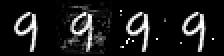

In [169]:
img_list = [img_orig, img_wachter, img_greedy, img_greedy_ensemble]
mosaic(img_list...,ncol=length(img_list))